In [2]:
%load_ext autoreload
%autoreload 2

# Doc-ID Reassignment

## 1. Data download

### Downloader instance

We download [RCV1 dataset](https://paperswithcode.com/dataset/rcv1), in particular we use tf-idf representation from [sklearn](https://scikit-learn.org/0.18/datasets/rcv1.html).

Create an instance of downloader.

In [3]:
from model.rcv1 import RCV1Downloader

downloader = RCV1Downloader()
downloader

RCV1Downloader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz; Downloaded: True]

### Download

Download the dataset.

In [4]:
%%time

downloader.download()

INFO: Dataset is already downloaded at /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz
CPU times: user 595 µs, sys: 119 µs, total: 714 µs
Wall time: 463 µs


## 2. Data Loading

### Loading collection configurations

Use dataset configuration specified in the *.settings.py* file.

In [5]:
from settings import DATACONFIG

config = DATACONFIG["tiny"]
config

tiny [Docs: 50000; Terms: 15000; Approximation error: 0.3; N Clusters: 150]

### Loader instance

Create an instance of dataloader.

In [6]:
from model.rcv1 import RCV1Loader

loader = RCV1Loader()
loader

RCV1Loader [File: /home/sebaq/Documents/GitHub/IR_project/dataset/data.npz]

### Load

We load data sorting terms by decreasing frequency.

We only keep the first documents and terms specified by the configuration file.

In [7]:
collection = loader.load(n_docs=config.docs, n_terms=config.terms)

In [8]:
collection

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

## 3. Computing *d*-gap

### *d*-gap instance

Create and instance of DGapComputation for the collection.

In [9]:
from model.d_gap import DGapComputation

dgap = DGapComputation(collection=collection, data_name=config.name)
dgap

DGapComputation(tiny)[Docs: 50000; Terms: 14980; Computed: False]

### Compute *d*-gap statistics

We compute *d*-gap in the given collection.

In [10]:
%%time

dgap.compute_d_gaps()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap.json. 
INFO: Computing average d-gap per term. 


100%|██████████| 50000/50000 [00:02<00:00, 18082.32it/s]

CPU times: user 2.77 s, sys: 2.9 ms, total: 2.77 s
Wall time: 2.77 s


In [11]:
avg_d_gaps = dgap.avg_d_gap_pterm
avg_d_gaps

array([12.87289, 13.70597, 13.79   , ..., 72.     , 80.     , 88.     ])

### Average *d*-gap per term plot

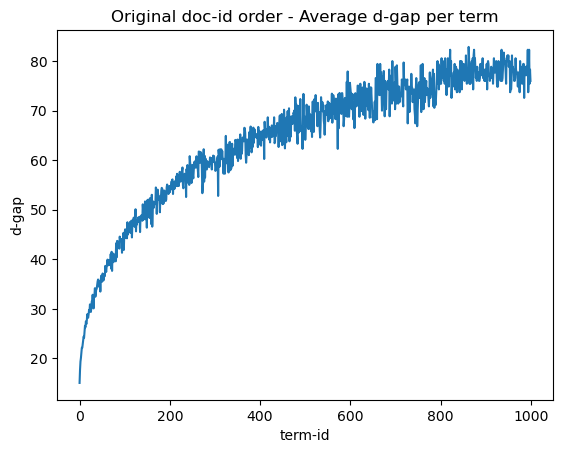

In [12]:
dgap.plot_avg_d_gap()

### Average *d*-gap

In [13]:
dgap.avg_d_gap

65.23313317089453

### Save statistics

We save statistics with in the directory with the specific configuration name: it will be no more necessary a second computation for further analysis.

In [14]:
dgap.save_d_gaps()

INFO: Saving average d-gap per term to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap.json. 


## 4. Dimensionality reduction

Clustering and TSP are expensive in a high dimensional and sparse vector space. We employ the [Johnson-Lindenstrauss lemma](https://scikit-learn.org/stable/modules/random_projection.html#the-johnson-lindenstrauss-lemma) to embed data points in a lower dense dimensional space through a random projection. Target dimension depends on an approximation factor specified in Dataset configuration.

### Approximation factor

The approximation factor is in range [0, 1]

In [15]:
eps = config.eps
eps

0.3

Project to embedded space.

In [16]:
embedded = collection.embed(eps=eps)
embedded.shape

(50000, 1202)

## 5. Clustering

### Compute number of clusters

We compute the number of cluster to find using a function specified in the configuration.

In [17]:
n_cluster = config.n_cluster
n_cluster

150

### Create K-Means instance

In [18]:
from model.clustering import KMeansClustering

kmeans = KMeansClustering(mat=embedded, data_name=config.name, k=n_cluster)

In [19]:
kmeans

KMeansClustering(tiny)[Items: 50000; k: 150; Labeling computed: False]

### Training model and retrieve labeling

In [20]:
%%time

kmeans.fit()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json. 
INFO: Fitting K-Means model. 
CPU times: user 3min 27s, sys: 12.6 s, total: 3min 40s
Wall time: 1min 7s


In [21]:
labeling = kmeans.labeling

labeling

array([110,  46, 118, ...,   7, 132, 132], dtype=int32)

### Save labeling

We save labeling on disk so we don't necessitate to compute again for further needs.

In [22]:
kmeans.save_labeling()

INFO: Saving labeling to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/labeling.json. 


## 6. Cluster split

### Get CollectionCluster instance

We split data in cluster using the labeling.

In [23]:
collection_clusters = kmeans.clusters

In [24]:
collection_clusters

RCV1Clusters(tiny)[Data: 50000, Clusters: 150, Mean-per-Cluster: 333.333; Medoids computed: False]

### Compute medoids

In [25]:
%%time

collection_clusters.compute_medoids()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 
INFO: Computing medoids. 


100%|██████████| 150/150 [00:00<00:00, 2916.68it/s]

CPU times: user 54.6 ms, sys: 4.17 ms, total: 58.7 ms
Wall time: 57.1 ms


In [26]:
medoids = collection_clusters.medoids

medoids.shape

(150, 1202)

In [27]:
medoids

array([[ 1.36403599e-03,  8.07088118e-02, -1.05565402e-03, ...,
        -4.34139044e-04,  8.09440817e-04, -4.18521386e-04],
       [-7.22301757e-06, -3.09195456e-04,  1.49991361e-02, ...,
         2.31018020e-04,  1.98448015e-03, -1.99378563e-03],
       [ 1.02311415e-02,  7.13199414e-03,  3.28259824e-03, ...,
        -4.53420618e-03,  9.81155511e-03, -2.61564926e-03],
       ...,
       [ 0.00000000e+00,  3.87379546e-02, -1.36323748e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 4.53715052e-02,  0.00000000e+00,  4.17127013e-02, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.11503065e-03,  2.76809460e-04, -8.20012600e-04, ...,
        -2.32124790e-03,  7.61700457e-04,  6.29590527e-05]])

### Save medoids

Save medoids on disk.

In [28]:
collection_clusters.save_medoids()

INFO: Saving medoids to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/medoids.npy. 


## 7. doc-*ID* reassignment

In [29]:
from model.reassignment import DocIdReassignmentComputation

reassignment_computation = DocIdReassignmentComputation(
    cluster=collection_clusters,
    data_name=config.name
)

reassignment_computation

INFO: Medoids already computed. Use `medoids` to retrieve them. 


DocIdReassignmentComputation(tiny)[]

In [30]:
reassignment_computation.solve()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/reassignment_order.json. 
INFO: Solving TSP over medoids 
INFO: Solving TSP. 
INFO: Solving cluster internal order


100%|██████████| 150/150 [00:00<00:00, 229.51it/s]


In [31]:
reassignment_computation.medoids_order

array([  2, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138,
       137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125,
       124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112,
       111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,  99,
        98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,
        85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,
        72,  71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,
        59,  58,  57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,
        46,  45,  44,  43,  42,  41,  40,  39,  38,  37,  36,  35,  34,
        33,  32,  31,  30,  29,  28,  27,  26,  25,  24,  23,  22,  21,
        20,  19,  18,  17,  16,  15,  14,  13,  12,  11,  10,   9,   8,
         7,   6,   5,   4,   3,   1,   0])

In [32]:
reassignment_computation.cluster_order

{0: array([ 15, 131, 181, 188, 279, 278, 174, 172, 141,  57,   9,  16, 170,
          8,   7, 276, 182, 115, 268, 105, 130, 103, 168, 270,  44,  43,
         90,  88, 184, 187, 116, 104, 132, 133, 156,  93, 208,  98, 167,
         92, 262,  91, 261, 229, 114, 102, 185, 274, 228, 179, 163, 166,
         29, 176, 183, 215, 159,  13, 173,  38, 272,  37, 277, 164,  51,
        259, 165, 123, 162, 186, 157, 197, 249, 281, 196,   4, 280, 180,
        232, 224,  56, 160, 195,  76,  26, 144,  73, 255, 211, 171, 257,
        118, 161,   6, 119,  82,  59, 169, 117, 121, 145, 203, 230, 231,
         23, 269,  21, 143, 210,  62, 136, 244, 129, 199,  60,  65, 209,
        198,   5, 126, 128,   3, 246, 248, 178, 140, 135, 223,   2, 134,
         81, 227,  34, 139, 245,  33, 252, 142, 107, 148, 271, 127, 101,
         85,  97,  20,  42, 149, 137, 147, 125, 155, 124,  36,  89, 122,
         19,  35, 100,   1, 120, 242,  41,  17, 264, 216, 177, 265,  32,
        263, 273, 219, 236,  99,  80,  31, 266, 

In [33]:
reassignment_computation.save_order()

INFO: Saving medoids and cluster order to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/reassignment_order.json 


In [34]:
from model.reassignment import DocIdReassignment

docs_reassignment = DocIdReassignment(
    collection=collection,
    labeling=labeling,
    medoids_order=reassignment_computation.medoids_order,
    clusters_order=reassignment_computation.cluster_order,
    data_name=config.name
)

docs_reassignment

DocIdReassignment[Items: 50000]

In [35]:
collection_reass = docs_reassignment.reassign_doc_id()

collection_reass

DataCollection [Docs: 50000; Terms: 14980; Nonzero: 1314210]

In [36]:
from model.d_gap import DGapComputationReassigned

dgap_reass = DGapComputationReassigned(collection=collection_reass, data_name=config.name)
dgap_reass

DGapComputation(tiny)[Docs: 50000; Terms: 14980; Computed: False]

In [37]:
dgap_reass.compute_d_gaps()

INFO: Information not present at /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap_reassigned.json. 
INFO: Computing average d-gap per term. 


100%|██████████| 50000/50000 [00:02<00:00, 16933.71it/s]


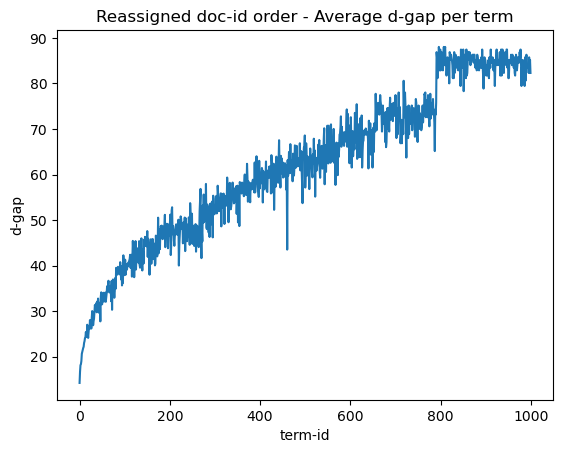

In [38]:
dgap_reass.plot_avg_d_gap()

In [39]:
dgap_reass.save_d_gaps()

INFO: Saving average d-gap per term to /home/sebaq/Documents/GitHub/IR_project/dataset/tiny/avg_d_gap_reassigned.json. 


## 8. Inference

In [43]:
from model.d_gap import DGapInference

inference = DGapInference(d_gap_original=dgap, d_gap_reassigned=dgap_reass, data_name=config.name)
inference

INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 
INFO: Average d-gaps already computed. Use `gaps_stats` to retrieve them. 


DGapInference[Terms: 14980]

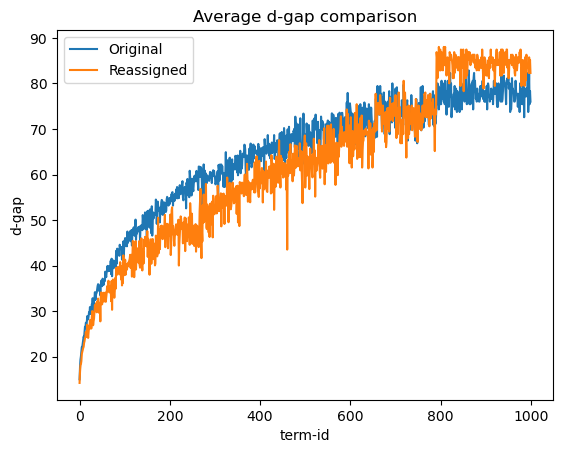

In [44]:
inference.plot_avg_d_gap()

In [46]:
inference.avg_compression

8.6481656017983